In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow import keras
from tensorflow.keras import layers

2024-10-10 13:00:10.753348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Table of contents

```
0. Introduction

1. Load the dataset
   -> LabelEncoder, StandardScaler, split_sequences, one-hot encoding

2. Build the model
   2.1. Transformer Encoder Block & Output Layer for classification
   2.2. Train and evaluate
```

# 0. Introduction

**Dataset**  
- [DSA](https://github.com/MyungKyuYi/AI-class/blob/main/Pre-trained_model.ipynb)

**Environment**
- macOS `x86`cpu

**Framework**  
- TensorFlow: Version `2.10.0`

**Dependencies**  
- Python: Version `3.9.18`
- Numpy: Version `1.26.4`
- Pandas: Version `2.2.2`
- Matplotlib: Version `3.9.2`
- scikit-learn: Version `1.5.1`

**Purpose**
- DSA 데이터셋에 대한 Classification.  
  데이터셋에 대한 부분은 [Github-rudevico](https://github.com/HyoYoonNam/DL-Class/blob/main/assignment/week3_LSTM_TransferLearning_HAR.ipynb)를 참고
- transformer의 encoder 부분만 구현하고, 출력용 output layer를 붙여서 model을 구현한다.
  + 해당 예제 데이터셋은 NLP와 같은 데이터가 아니기 때문에, word embedding 및 positional embedding은 필요하지 않다.

**References**  
- [Timeseries classification with a Transformer model](https://keras.io/examples/timeseries/timeseries_classification_transformer/)
- [The Transformer Model - MachineLearningMastery.com](https://machinelearningmastery.com/the-transformer-model/)

* * *

- 기본적으로 transformer는 attention에만 의존하기 때문에, 제대로 된 성능을 내려면 매우 많은 데이터가 필요하다.  
  따라서 해당 task의 경우 CNN으로 구현했을 때보다 accuracy가 낮은 것을 확인할 수가 있다.
- 기본적인 transformer encoder 뒤에 CNN 등의 layer를 추가로 붙인다면, 데이터가 비교적 적어도 좋은 성능을 낼 수 있다.

* * *
- train set accuracy: 0.5422638058662415
- test  set accuracy: 0.39683932065963745

# 1. Load the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('./datasets/DSA_features.csv')
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [4]:
# string -> int로 바꾸는 LabelEncoder 사용
from sklearn.preprocessing import LabelEncoder

# 기존 데이터프레임에서 'activity' 열을 origin_label로 저장
origin_label = df['activity'].copy()

# LabelEncoder를 이용해 'activity' 열을 정수형으로 변환
label_encoder = LabelEncoder()
df['activity'] = label_encoder.fit_transform(df['activity'])

# 문자열과 정수 값 매핑을 데이터프레임으로 생성
df_mapping = pd.DataFrame({
    'origin_label': label_encoder.classes_,
    'encoded_label': label_encoder.transform(label_encoder.classes_)
})

# 결과 출력
print(df_mapping)

               origin_label  encoded_label
0           ascendingStairs              0
1                basketBall              1
2              crossTrainer              2
3         cyclingHorizontal              3
4           cyclingVertical              4
5           decendingStairs              5
6                   jumping              6
7                 lyingBack              7
8                 lyingRigh              8
9          movingInElevator              9
10                   rowing             10
11         runningTreadmill             11
12                  sitting             12
13                 standing             13
14  standingInElevatorStill             14
15                  stepper             15
16               walkingLot             16
17     walkingTreadmillFlat             17
18  walkingTreadmillIncline             18


In [5]:
X = df.drop(['activity', 'people'], axis=1).to_numpy()
y = df['activity'].to_numpy()

In [6]:
# train, test 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Sequential dataset 만들기
from collections import Counter

def split_sequences_classification_majority(data, labels, n_steps):
    """
    비연속 데이터셋을 일정한 길이의 연속적인 시퀀스로 변환하는 함수
    window에서 다수를 차지하는 label로 결정
    
    Args:
    data: 원본 데이터 (리스트 또는 배열)
    labels: 각 데이터에 해당하는 클래스 라벨 (리스트 또는 배열)
    n_steps: 시퀀스의 길이 (정수)
    
    Returns:
    X: 입력 시퀀스
    y: 해당 시퀀스에 대한 다수 라벨
    """
    X, y = [], []
    
    for i in range(len(data) - n_steps + 1):
        # 시퀀스 추출
        seq_x = data[i:i + n_steps]
        seq_labels = labels[i:i + n_steps]
        
        # 시퀀스의 라벨 중 가장 빈번한 라벨을 선택 (다수결)
        most_common_label = Counter(seq_labels).most_common(1)[0][0]
        
        X.append(seq_x)
        y.append(most_common_label)
    
    return np.array(X), np.array(y)

In [9]:
n_steps = 3
X_train_seq, y_train_seq = split_sequences_classification_majority(X_train,
                                                                   y_train,
                                                                   n_steps)
X_test_seq, y_test_seq = split_sequences_classification_majority(X_test,
                                                                 y_test,
                                                                 n_steps)

print(f"X_train_seq.shape: {X_train_seq.shape}", end=" ")
print(f"y_train_seq.shape: {y_train_seq.shape}")
print(f"X_test_seq.shape: {X_test_seq.shape}", end=" ")
print(f"y_test_seq.shape: {y_test_seq.shape}")

X_train_seq.shape: (6838, 3, 270) y_train_seq.shape: (6838,)
X_test_seq.shape: (2278, 3, 270) y_test_seq.shape: (2278,)


In [10]:
# one-hot encoding
import tensorflow.keras as keras

y_train_seq = keras.utils.to_categorical(y_train_seq)
y_test_seq = keras.utils.to_categorical(y_test_seq)

print("==== one-hot encoded ====")
print(f"y_train_seq.shape: {y_train_seq.shape}")
print(f"y_test_seq.shape: {y_test_seq.shape}")

==== one-hot encoded ====
y_train_seq.shape: (6838, 19)
y_test_seq.shape: (2278, 19)


# 2. Build the model

## 2.1. Transformer Encoder Block & Output Layer for classification

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
# Transformer Encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    inputs를 받아서 multi-head attention을 수행하는 transformer encoder block
    
    num_heads: multi-head attention에서 head의 수 지정
    """
    
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Skip connection
    
    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [13]:
def build_model(input_shape, head_size, num_heads, ff_dim,
                num_transformer_blocks, mlp_units, n_classes, 
                dropout=0, mlp_dropout=0,):
    """
    num_transformer_blocks: transformer encoder block 몇 개나 이어서 붙일 지
    n_classes: Number of output classes
    """
    inputs = keras.Input(shape=input_shape)  # input_shape = (3, 270)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling to reduce the dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    
    # Dense MLP layers
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    ###added
    # Output layer for classification with 19 classes
    outputs = layers.Dense(n_classes, activation="softmax", name='output')(x)
    
    return keras.Model(inputs, outputs)

In [14]:
# Define model parameters
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
head_size = 64
num_heads = 4
ff_dim = 128
num_transformer_blocks = 3 # 많을수록 학습 시간 오래 걸림
mlp_units = [128, 64]
n_classes = y_train_seq.shape[1]  # for y_train_seq shape (6838, 19)
dropout = 0.1
mlp_dropout = 0.1

In [15]:
# Build and compile the model
model = build_model(input_shape, head_size, num_heads, ff_dim, 
                    num_transformer_blocks, mlp_units, n_classes, 
                    dropout, mlp_dropout)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  # Assuming you have one-hot encoded y_train_seq
    metrics=["accuracy"]
)

model.summary()

2024-10-10 13:00:13.378035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 270)]     0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 3, 270)      277518      ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 3, 270)       0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 3, 270)      540         ['dropout[0][0]']            

## 2.2. Train and evaluate

In [16]:
history = model.fit(X_train_seq, y_train_seq, 
                    epochs=50, 
                    batch_size=512, 
                    validation_split=0.1, 
                    shuffle=True,
                    verbose=2)

Epoch 1/50
13/13 - 3s - loss: 4.4840 - accuracy: 0.0973 - val_loss: 2.8214 - val_accuracy: 0.1345 - 3s/epoch - 260ms/step
Epoch 2/50
13/13 - 1s - loss: 2.8320 - accuracy: 0.1573 - val_loss: 2.5995 - val_accuracy: 0.2237 - 1s/epoch - 91ms/step
Epoch 3/50
13/13 - 1s - loss: 2.6603 - accuracy: 0.1948 - val_loss: 2.4812 - val_accuracy: 0.2632 - 1s/epoch - 92ms/step
Epoch 4/50
13/13 - 1s - loss: 2.5600 - accuracy: 0.2249 - val_loss: 2.4064 - val_accuracy: 0.2500 - 1s/epoch - 88ms/step
Epoch 5/50
13/13 - 1s - loss: 2.4453 - accuracy: 0.2483 - val_loss: 2.3299 - val_accuracy: 0.2705 - 1s/epoch - 88ms/step
Epoch 6/50
13/13 - 1s - loss: 2.4104 - accuracy: 0.2499 - val_loss: 2.2997 - val_accuracy: 0.2909 - 1s/epoch - 87ms/step
Epoch 7/50
13/13 - 1s - loss: 2.3199 - accuracy: 0.2814 - val_loss: 2.2262 - val_accuracy: 0.3085 - 1s/epoch - 84ms/step
Epoch 8/50
13/13 - 1s - loss: 2.2738 - accuracy: 0.2831 - val_loss: 2.1385 - val_accuracy: 0.3260 - 1s/epoch - 85ms/step
Epoch 9/50
13/13 - 1s - loss: 2

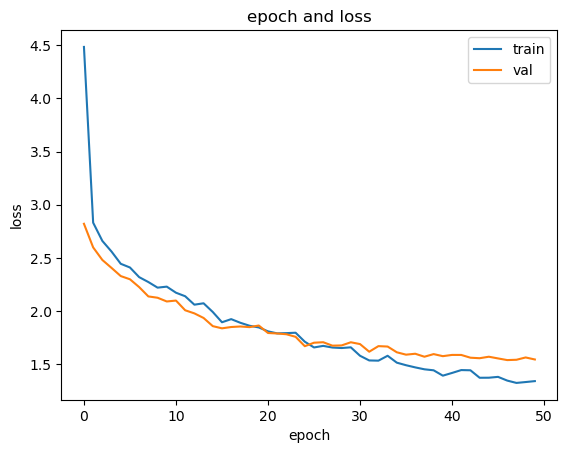

In [21]:
# epoch에 따른 loss
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('epoch and loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [22]:
# train set에 대한 loss와 accuracy
model.evaluate(X_train_seq, y_train_seq)

214/214 [==============================] - 1s 4ms/step - loss: 1.1508 - accuracy: 0.5423


[1.1507978439331055, 0.5422638058662415]

In [23]:
# test set에 대한 loss와 accuracy
model.evaluate(X_test_seq, y_test_seq)

72/72 [==============================] - 0s 4ms/step - loss: 1.4730 - accuracy: 0.3968


[1.4729634523391724, 0.39683932065963745]

72/72 [==============================] - 0s 4ms/step
Confusion Matrix


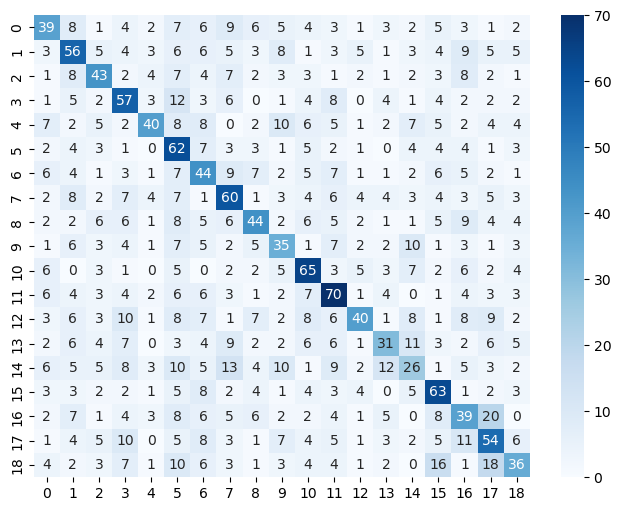

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test_seq, axis=1)
Y_pred = np.argmax(model.predict(X_test_seq),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)
# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# 그래프 표시
plt.show()